In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package wordnet to /Users/fadhil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# train_data = pd.read_csv('data/lab_train.csv')

# Fadel
train_data = pd.read_csv('./Lab1/lab_train.txt', sep=",")

train_data = train_data[['review', 'score']]


train_data.head()

,review,score
0,Before I begin I'd just like point out that I ...,1.0
1,I love all 4 of the movies. The way the storyl...,5.0
2,i love this movie. it is something i would cal...,5.0
3,"I really enjoy this movie so much,that I told ...",5.0
4,Having been a fan of Walt Disney movies for ye...,5.0


In [5]:
# test_data = pd.read_csv('data/lab_test.csv')

test_data = pd.read_csv('./Lab1/lab_test.txt', sep=",")

test_data = test_data[['review', 'score']]
test_data.head()

,review,score
0,How I thank the Lord for this DVD and movie......,5.0
1,A chance meeting on a train changes the life o...,5.0
2,Although I bought this box set only a week or ...,5.0
3,This film has tons of highlights. The waxing s...,4.0
4,"""Shaun"" is supposed to be a comedic 'spoof' an...",4.0


In [199]:
hotel_review_data = pd.read_csv('data/evaluation_dataset.csv')
hotel_review_data_cleaned = data_preprocess_lemmatize(hotel_review_data.copy())
hotel_review_data_cleaned.head()

,review
0,thecheckinstaffwereveryfriendlyandcouldnotdoen...
1,theroomwagreatmoderncleanrobeslipperwereawelco...
2,thisisagreathotelthestaffareveryfriendlyandpro...
3,thepriceoftheroomwhichwestayedinwawithoutbreak...
4,theparkingfacilityareexcellentbutdidfindthecha...


In [6]:
def naive_bayes_clf(train, test, vectorizer, ngram_range = None):
    ## generate train and test data

    if vectorizer == 'cv':
        vctr = CountVectorizer()
    elif vectorizer == 'ngram':
        vctr = CountVectorizer(ngram_range=ngram_range)
    elif vectorizer == 'tfidf':
        vctr = TfidfVectorizer(ngram_range=ngram_range)
    
    train_review = vctr.fit_transform(train['review'])
    test_review = vctr.transform(test['review'])

    train_label = train['sentiment']
    test_label = test['sentiment']
    
    ## create naive bayes model
    clf = GaussianNB()
    clf.fit(train_review.toarray(), train_label)

    label_pred = clf.predict(test_review.toarray())

    # generate confusion matrix of the prediction
    cm = confusion_matrix(test_label, label_pred)
    
    return label_pred, cm, clf

In [14]:
def svm_clf(train, test, vectorizer, ngram_range = None):
    ## generate train and test data

    if vectorizer == 'cv':
        vctr = CountVectorizer()
    elif vectorizer == 'ngram':
        vctr = CountVectorizer(ngram_range=ngram_range)
    elif vectorizer == 'tfidf':
        vctr = TfidfVectorizer(ngram_range=ngram_range)
    
    train_review = vctr.fit_transform(train['review'])
    test_review = vctr.transform(test['review'])

    train_label = train['sentiment']
    test_label = test['sentiment']
    
    ## create naive bayes model
    clf = LinearSVC()
    clf.fit(train_review.toarray(), train_label)

    label_pred = clf.predict(test_review.toarray())

    # generate confusion matrix of the prediction
    cm = confusion_matrix(test_label, label_pred)
    
    return label_pred, cm, clf

### Experiment 1 (Stemming only)

In [23]:
#mapping score to sentiment
def map_score(data):
#     data['sentiment'] = 0
    data.loc[data['score'] >= 3, 'sentiment'] = 1
    data.loc[data['score'] < 3, 'sentiment'] = -1
    
    return data

In [8]:
def data_preprocess(data, norm_type):
    replace_no_space = re.compile("(\\n)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
    replace_with_space = re.compile("(<[^>]*>)|(<br\s*/><br\s*/>)|(\-)|(\/)|([^a-zA-z])")
    stop_words = ['in', 'of', 'the', 'at', 'a', 'an', 'is', 'are', 'am', 'was', 'were']
    
    data['review'] = data['review'].str.lower()
    
    data['review'] = [''.join(replace_no_space.sub("", x)) for x in data['review'].tolist()] #remove special char
    data['review'] = [''.join(replace_with_space.sub(" ", x)) for x in data['review'].tolist()] #remove special char
    
    data['review'] = [' '.join([word for word in x.split() if word not in stop_words]) 
                               for x in data['review'].tolist()] # remove stop words
    
    if norm_type == 'stem':
        normalizer = PorterStemmer()
        data['review'] = [' '.join([normalizer.stem(word) for word in x.split()]) 
                               for x in data['review'].tolist()] #stem words
    elif norm_type == 'lemma':
        normalizer = WordNetLemmatizer()
        data['review'] = [' '.join([normalizer.lemmatize(word) for word in x.split()]) 
                               for x in data['review'].tolist()] #lemmatize words
        
    return data

In [15]:
def plot_cm(cm):
    labels = ['negative', 'positive']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the sentiment analysis')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [24]:
df_train_data = train_data.copy()
df_test_data = test_data.copy()

## map score to sentiment
df_train_data = map_score(df_train_data)
df_test_data = map_score(df_test_data)

## preprocess data
df_train_data = data_preprocess(df_train_data, 'stem')
df_test_data = data_preprocess(df_test_data, 'stem')

In [25]:
## build model an predict
label_pred, cm, clf = naive_bayes_clf(df_train_data, df_test_data, 'cv')

In [26]:
## build model an predict using SVC
label_pred, cm, clf = svm_clf(df_train_data, df_test_data, 'cv')

In [27]:
cm

array([[ 3,  9],
       [ 5, 83]])

In [241]:
vctr = TfidfVectorizer()
vctr.fit(df_train_data['review'])
hotel_review_data_vec = vctr.transform(hotel_review_data_cleaned['review'])
res = clf.predict(hotel_review_data_vec.toarray())

In [242]:
hotel_review_data['sentiment'] = res
hotel_review_data.head()

,review,sentiment
0,The check in staff were very friendly and coul...,1
1,The room was great - modern & clean. Robes & s...,1
2,This is a great hotel. The staff are very frie...,1
3,The price of the room which we stayed in was £...,1
4,The parking facilities are excellent but did f...,0


In [243]:
hotel_review_data.sentiment.value_counts()

 1    160
 0     24
-1     16
Name: sentiment, dtype: int64

In [244]:
hotel_review_data.to_csv('data/hotel_review_sentiment_newest.csv')

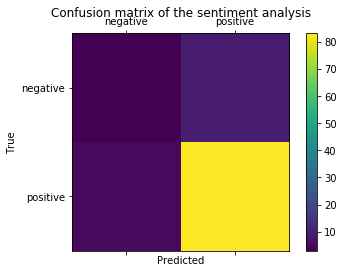

In [28]:
plot_cm(cm)

In [246]:
cm

array([[ 1,  0, 11],
       [ 0,  0,  9],
       [ 3,  3, 73]], dtype=int64)

### Experiment 2 (Lemmatize)

In [20]:
df_train_data = train_data.copy()
df_test_data = test_data.copy()

## map score to sentiment
df_train_data = map_score(df_train_data)
df_test_data = map_score(df_test_data)

## preprocess data
df_train_data = data_preprocess(df_train_data, 'lemma')
df_test_data = data_preprocess(df_test_data, 'lemma')

In [21]:
## build model an predict
label_pred, cm, clf = svm_clf(df_train_data, df_test_data, 'cv')

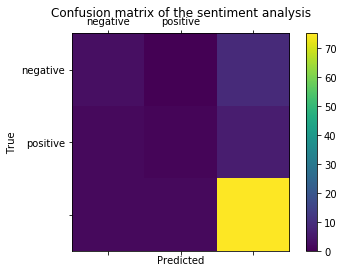

In [22]:
plot_cm(cm)

In [253]:
cm

array([[ 1,  0, 11],
       [ 0,  0,  9],
       [ 3,  2, 74]], dtype=int64)

### Experiment 3 - Lemmatize + n-gram

In [255]:
df_train_data = train_data.copy()
df_test_data = test_data.copy()

## map score to sentiment
df_train_data = map_score(df_train_data)
df_test_data = map_score(df_test_data)

## preprocess data
df_train_data = data_preprocess(df_train_data, 'lemma')
df_test_data = data_preprocess(df_test_data, 'lemma')

In [258]:
## build model an predict
label_pred, cm, clf = naive_bayes_clf(df_train_data, df_test_data, 'ngram', (1,3))

In [259]:
cm

array([[ 0,  0, 12],
       [ 0,  0,  9],
       [ 1,  1, 77]], dtype=int64)

### Experiment 4 - Lemmatize + tf-idf

In [272]:
df_train_data = train_data.copy()
df_test_data = test_data.copy()

## map score to sentiment
df_train_data = map_score(df_train_data)
df_test_data = map_score(df_test_data)

## preprocess data
df_train_data = data_preprocess(df_train_data, 'lemma')
df_test_data = data_preprocess(df_test_data, 'lemma')

In [275]:
## build model an predict
label_pred, cm, clf = naive_bayes_clf(df_train_data, df_test_data, 'tfidf', (1,3))

In [276]:
cm

array([[ 0,  0, 12],
       [ 0,  0,  9],
       [ 1,  1, 77]], dtype=int64)

### Experiment 5 - over/under sampling

In [291]:
def naive_bayes_clf_sampling(train, test, vectorizer, sampling_type, ngram_range = None):
    ## generate train and test data

    if vectorizer == 'cv':
        vctr = CountVectorizer()
    elif vectorizer == 'ngram':
        vctr = CountVectorizer(ngram_range=ngram_range)
    elif vectorizer == 'tfidf':
        vctr = TfidfVectorizer(ngram_range=ngram_range)
    
    train_review = vctr.fit_transform(train['review'])
    test_review = vctr.transform(test['review'])

    train_label = train['sentiment']
    test_label = test['sentiment']
    
    if sampling_type == 'over':
        ros = RandomOverSampler(random_state=10)
        ros_train_review, ros_train_label = ros.fit_sample(train_review, train_label)
    elif sampling_type == 'under':
        ros = RandomUnderSampler(random_state=10)
        ros_train_review, ros_train_label = ros.fit_sample(train_review, train_label)        
    
    print(len(ros_train_label))
    ## create naive bayes model
    clf = GaussianNB()
    clf.fit(ros_train_review.toarray(), ros_train_label)

    label_pred = clf.predict(test_review.toarray())

    # generate confusion matrix of the prediction
    cm = confusion_matrix(test_label, label_pred)
    
    return label_pred, cm

In [277]:
df_train_data = train_data.copy()
df_test_data = test_data.copy()

## map score to sentiment
df_train_data = map_score(df_train_data)
df_test_data = map_score(df_test_data)

## preprocess data
df_train_data = data_preprocess(df_train_data, 'lemma')
df_test_data = data_preprocess(df_test_data, 'lemma')

In [285]:
len(test_data)

100

In [292]:
## build model an predict
label_pred, cm = naive_bayes_clf_sampling(df_train_data, df_test_data, 'tfidf', 'under', (1,2))

45


In [293]:
cm

array([[ 1,  7,  4],
       [ 1,  5,  3],
       [ 7, 37, 35]], dtype=int64)

In [81]:
from scipy.stats import itemfreq
itemfreq(ros_train_label)

E:\Anaconda\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


array([[ -1, 158],
       [  0, 158],
       [  1, 158]], dtype=int64)

### Use different data for model building

In [20]:
data_imdb = pd.read_csv('data/imdb_master.csv', encoding='latin-1')
data_imdb = data_imdb.drop(data_imdb.columns[[-1,0]], axis=1)
data_imdb = data_imdb[data_imdb.label != 'unsup']
data_imdb.loc[data_imdb.label == 'pos', 'sentiment'] = 1
data_imdb.loc[data_imdb.label == 'neg', 'sentiment'] = -1
data_imdb_train = data_imdb[data_imdb.type == 'train'][['review', 'sentiment']].reset_index(drop = True)
data_imdb_test = data_imdb[data_imdb.type == 'test'][['review', 'sentiment']].reset_index(drop = True)
data_imdb_train = data_imdb_train.sample(frac=0.1).reset_index(drop = True)
data_imdb_test = data_imdb_test.sample(frac=0.1).reset_index(drop = True)

In [21]:
df_train_data = data_preprocess(data_imdb_train, 'lemma')
df_test_data = data_preprocess(data_imdb_test, 'lemma')

In [22]:
label_pred, cm, clf = naive_bayes_clf(df_train_data, df_test_data, 'tfidf', (1,2))

In [37]:
accuracy_score(label_pred, data_imdb_test.sentiment)

0.7112

In [39]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import average_re
average_precision = average_precision_score(label_pred, data_imdb_test.sentiment)
average_precision

0.6524214656857263

In [41]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall = precision_recall_fscore_support(label_pred, data_imdb_test.sentiment)
precision_recall

(array([0.70991136, 0.71247021]),
 array([0.70876911, 0.71360382]),
 array([0.70933977, 0.71303657]),
 array([1243, 1257], dtype=int64))

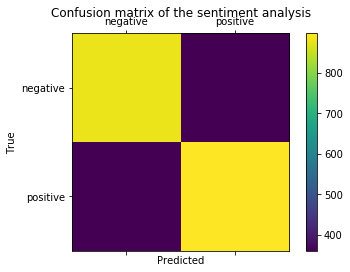

In [33]:
plot_cm(cm)

In [16]:
cm

array([[908, 327],
       [360, 905]], dtype=int64)

In [17]:
hotel_review_data = pd.read_csv('data/evaluation_dataset.csv')
hotel_review_data = data_preprocess(hotel_review_data, 'lemma')
hotel_review_data.head()

,review
0,check staff very friendly and could not do eno...
1,room great modern clean robe slipper welcome t...
2,this great hotel staff very friendly and profe...
3,price room which we stayed without breakfast i...
4,parking facility excellent but did find charge...


In [23]:
vctr = TfidfVectorizer(ngram_range=(1,2))
vctr.fit(df_train_data['review'])
hotel_review_data_vec = vctr.transform(hotel_review_data['review'])
res = clf.predict(hotel_review_data_vec.toarray())

In [25]:
hotel_review_data['sentiment'] = res
hotel_review_data.head()

,review,sentiment
0,check staff very friendly and could not do eno...,1.0
1,room great modern clean robe slipper welcome t...,1.0
2,this great hotel staff very friendly and profe...,1.0
3,price room which we stayed without breakfast i...,-1.0
4,parking facility excellent but did find charge...,1.0


In [27]:
hotel_review_data.sentiment.value_counts()

 1.0    118
-1.0     82
Name: sentiment, dtype: int64

In [26]:
hotel_review_data.to_csv('data/latest.csv', index=False)

In [29]:
result = pd.read_csv('data/latest.csv')
result.head()

,review,sentiment,label
0,check staff very friendly and could not do eno...,1,1
1,room great modern clean robe slipper welcome t...,1,1
2,this great hotel staff very friendly and profe...,1,1
3,price room which we stayed without breakfast i...,-1,-1
4,parking facility excellent but did find charge...,1,1


In [31]:
cm_res = confusion_matrix(result.sentiment, result.label)
cm_res

array([[43, 39],
       [37, 81]], dtype=int64)

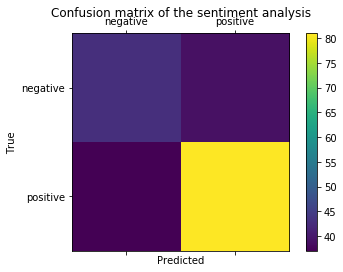

In [34]:
plot_cm(cm_res)

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(result.sentiment, result.label)

0.62

In [42]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall = precision_recall_fscore_support(result.sentiment, result.label)
precision_recall

(array([0.5375, 0.675 ]),
 array([0.52439024, 0.68644068]),
 array([0.5308642 , 0.68067227]),
 array([ 82, 118], dtype=int64))

In [354]:
df_train_data.iloc[5].review

'i still cant believe how bad this movie wa if i wasnt massochist i dont know if i would have survived viewing it look like it cost about to make but it wasnt money that brought them down acting wa horrid not just bad rd grader could have read line better second only other reason to watch this kind movie skin and that sorely lacking this flick we dont even get to see more attractive chicas buff ahh well better luck next time eh'

In [311]:
data_movie_review[data_movie_review.label == 'pos'].iloc[0].review

"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."

In [303]:
data_movie_review.iloc[7].review

'privilege watching scarface big screen beautifully restored mm print honor th anniversary films release great see big screen much lost television sets overall largesse project cannot emphasized enough scarface remake classic rags riches depths hell story featuring al pacino cuban drug lord tony montana version tony comes america cuban boat people immigration wave late s early s tony cohorts quickly get green cards offing political figure tent city brief stay cuban restaurant tony launched horrific path towards total destruction many characters movie played skilled manner enjoyable watch forgot little film last twenty years robert loggia tony s patron frank lopez wonderful character flawed trusting tony quickly figures out soft lopez s right hand omar suarez portrayed one greatest actors f murray abraham amadeus suarez ultimate toady anything frank like mind own tony quickly sees constantly battles suarez really sees minor problem get way top character always comes back played perfectl